In [2]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
from urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

2023-07-03 11:13:29.832737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 11:13:30.986283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# @title Run this!!

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Beach' : '../models/research/object_detection/test_images/image2.jpg',
  'Dogs' : '../models/research/object_detection/test_images/image1.jpg',
  # By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  'Phones' : 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg',
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1),
 (0, 2),
 (1, 3),
 (2, 4),
 (0, 5),
 (0, 6),
 (5, 7),
 (7, 9),
 (6, 8),
 (8, 10),
 (5, 6),
 (5, 11),
 (6, 12),
 (11, 12),
 (11, 13),
 (13, 15),
 (12, 14),
 (14, 16)]

In [4]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [5]:
PATH_TO_LABELS = '../models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [6]:
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512'
# 'Mask R-CNN Inception ResNet V2 1024x1024'
#  'CenterNet HourGlass104 Keypoints 512x512'

# @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


In [9]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...


2023-07-01 22:31:10.650359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 22:31:10.933078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 22:31:10.933257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 22:31:10.935515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 22:31:10.935568: I tensorflow/compile

model loaded!


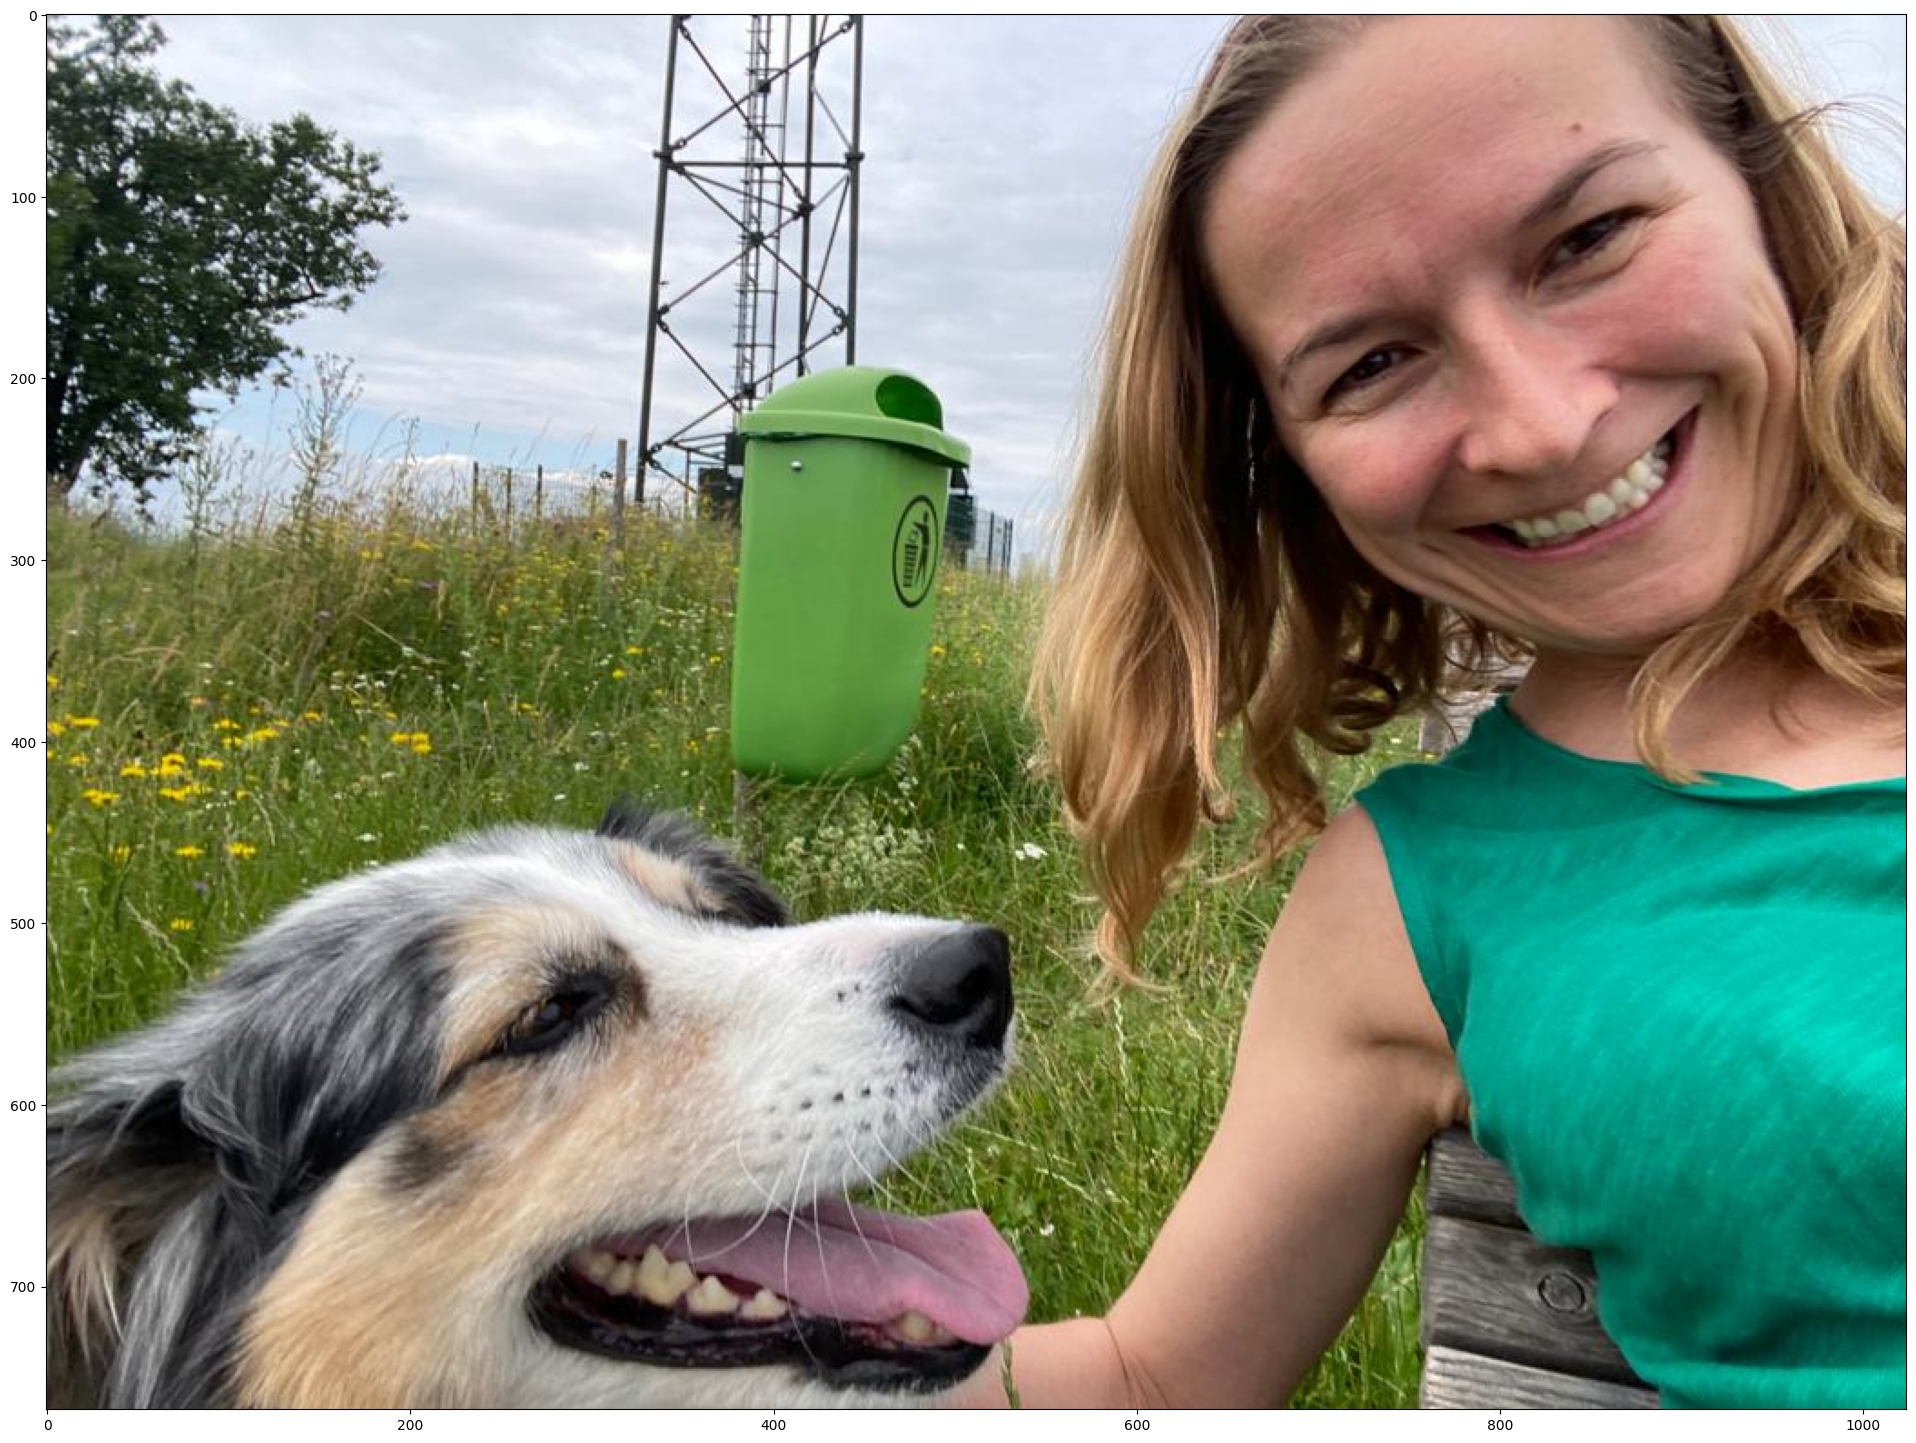

In [10]:
flip_image_horizontally = False
convert_image_to_grayscale = False

image_path = 'data/bettina.jpg'
image_np = load_image_into_numpy_array(image_path)

# Flip horizontally
if(flip_image_horizontally):
  image_np[0] = np.fliplr(image_np[0]).copy()

# Convert image to grayscale
if(convert_image_to_grayscale):
  image_np[0] = np.tile(
    np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

plt.figure(figsize=(24,32))
plt.imshow(image_np[0])
plt.show()

In [11]:
# running inference
results = hub_model(image_np)

# different object detection models have additional results
# all of them are explained in the documentation
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

2023-07-01 22:31:55.392043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_tensor' with dtype uint8 and shape [1,?,?,3]
	 [[{{node input_tensor}}]]
2023-07-01 22:31:56.031603: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/cond/then/_918/cond/Assert_3/AssertGuard/branch_executed/_1132
2023-07-01 22:32:05.179102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-01 22:32:11.493385: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-01 22:32:17.569392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will

dict_keys(['detection_classes', 'detection_keypoint_scores', 'detection_keypoints', 'num_detections', 'detection_boxes', 'detection_scores'])


In [12]:
result['detection_boxes']

array([[[5.71472168e-01, 0.00000000e+00, 9.96074677e-01, 5.35257220e-01],
        [8.62876594e-04, 3.69865060e-01, 9.89645660e-01, 9.97395635e-01],
        [8.50263119e-01, 2.81833440e-01, 9.77076054e-01, 5.22269905e-01],
        [2.47573972e-01, 3.65562230e-01, 5.54264128e-01, 4.98397619e-01],
        [8.05236518e-01, 7.41075695e-01, 9.95728850e-01, 8.61246645e-01],
        [9.50336695e-01, 7.41418242e-01, 9.99651670e-01, 8.62403035e-01],
        [9.33457851e-01, 4.06772375e-01, 9.89856243e-01, 5.07241368e-01],
        [2.47573972e-01, 3.65562230e-01, 5.54264128e-01, 4.98397619e-01],
        [6.56750321e-01, 7.30597973e-01, 1.00000000e+00, 8.84001732e-01],
        [5.33457696e-01, 7.01886296e-01, 9.97593999e-01, 8.83693695e-01],
        [5.32557905e-01, 6.88174963e-01, 9.98601556e-01, 9.44812059e-01],
        [5.50121903e-01, 7.35670090e-01, 1.00000000e+00, 9.91803288e-01],
        [3.78031909e-01, 6.80731058e-01, 1.00000000e+00, 9.83452797e-01],
        [6.12719417e-01, 7.34696329e-0

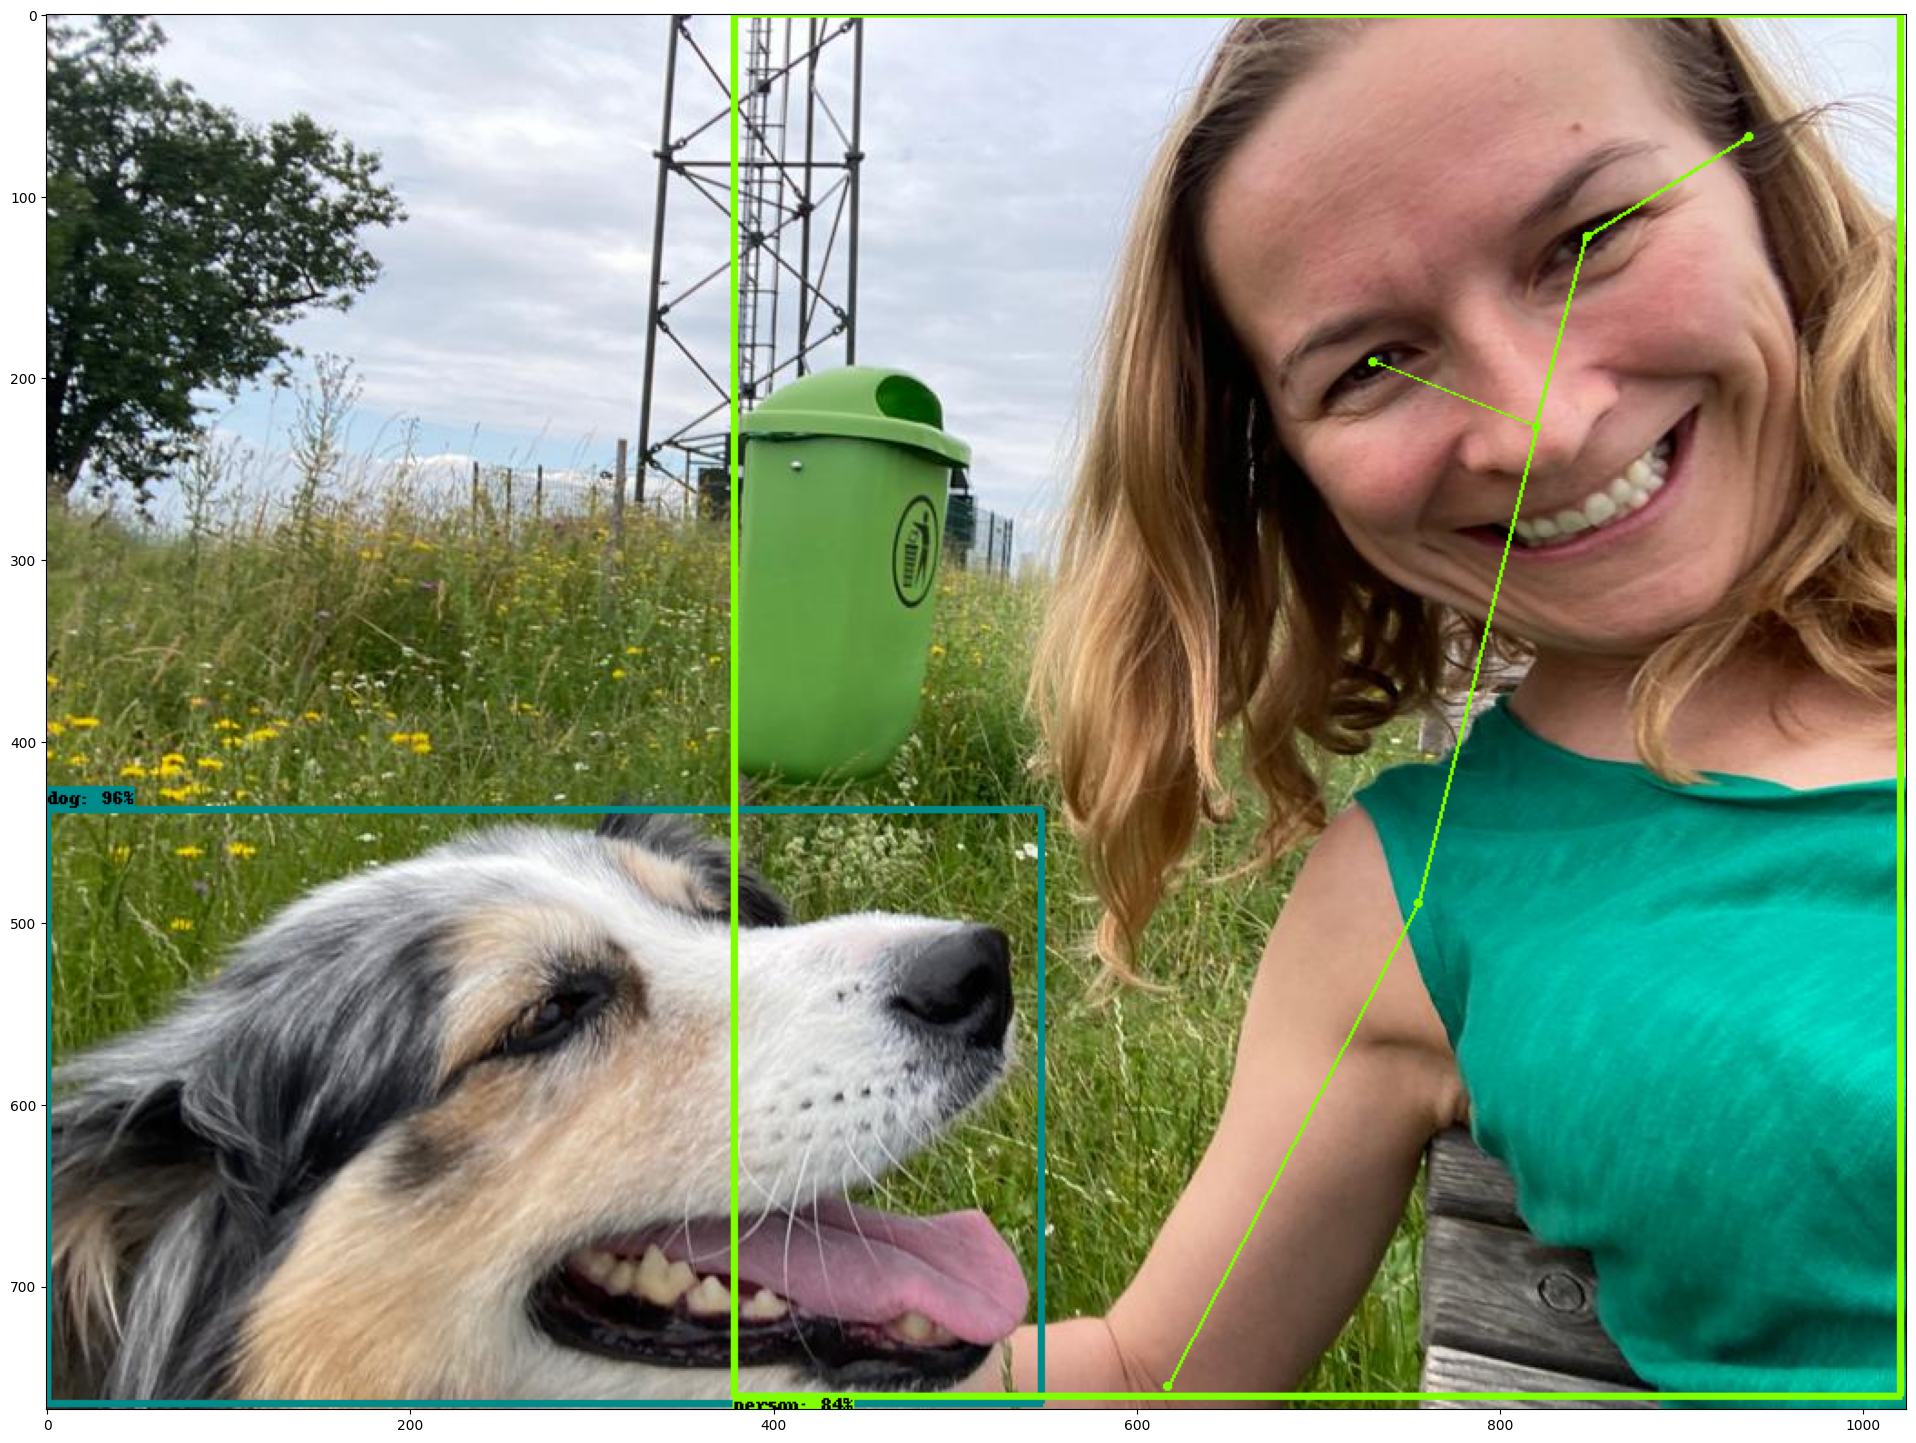

In [13]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in result:
  keypoints = result['detection_keypoints'][0]
  keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

In [14]:
x = tf.keras.applications.vgg19.preprocess_input(image_np)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)

2023-07-01 22:37:27.851881: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


(1, 1000)


In [15]:
tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())

[[('n02106030', 'collie', 0.28454205),
  ('n02105855', 'Shetland_sheepdog', 0.24530438),
  ('n02111500', 'Great_Pyrenees', 0.2331334),
  ('n02107683', 'Bernese_mountain_dog', 0.07141318),
  ('n02106166', 'Border_collie', 0.040699743)]]

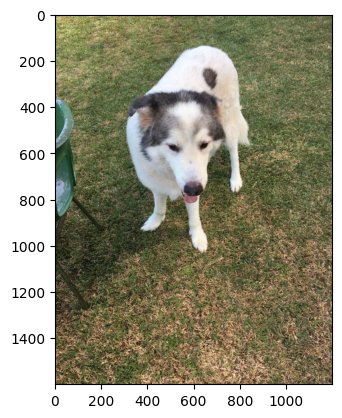

In [12]:
chief = load_image_into_numpy_array('data/chief.jpg')
plt.imshow(chief[0])

In [13]:
x = tf.keras.applications.vgg19.preprocess_input(chief)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())

[[('n02110185', 'Siberian_husky', 0.3348259),
  ('n02110063', 'malamute', 0.23804358),
  ('n02109961', 'Eskimo_dog', 0.12723231),
  ('n02111500', 'Great_Pyrenees', 0.07396227),
  ('n02111889', 'Samoyed', 0.027778894)]]

In [9]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

2023-07-01 22:58:19.612323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 22:58:19.724602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 22:58:19.724666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 22:58:19.727102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-01 22:58:19.727156: I tensorflow/compile

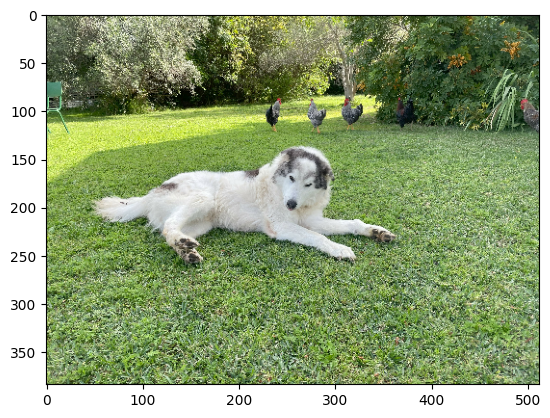

In [7]:
chief2 = load_img('data/chief2.jpg')
plt.imshow(chief2[0])

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(chief2)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())

2023-07-01 22:58:29.771305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-01 22:58:31.497327: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-01 22:58:34.089915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[[('n03729826', 'matchstick', 0.07613519),
  ('n01930112', 'nematode', 0.055718698),
  ('n03196217', 'digital_clock', 0.031202165),
  ('n03666591', 'lighter', 0.026779938),
  ('n04286575', 'spotlight', 0.026548548)]]

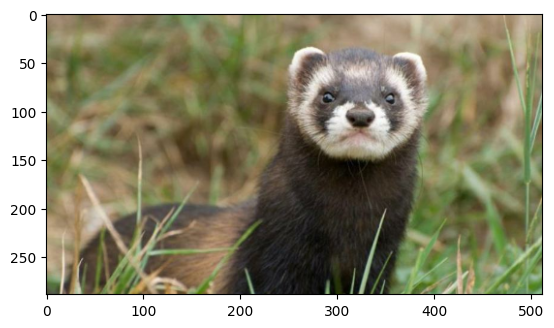

In [15]:
ferret = load_img('data/ferret.jpg')
plt.imshow(ferret[0])

In [18]:
x = tf.keras.applications.vgg19.preprocess_input(chief)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())

2023-07-03 11:17:38.525548: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-07-03 11:17:38.525619: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-07-03 11:17:38.525630: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 42, Chunks in use: 42. 10.5KiB allocated for chunks. 10.5KiB in use in bin. 3.2KiB client-requested in use in bin.
2023-07-03 11:17:38.525637: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 12, Chunks in use: 12. 6.2KiB allocated for chunks. 6.2KiB in use in bin. 6.0KiB client-requested in use in bin.
2023-07-03 11:17:38.525642: I tensorflo

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]